<img align="center" src="../extra/logos/logos.png" width='1200px'>

# Replicación de un estudio de caso

Este es parte de un ensayo para el monitoreo de humedales en la tercera región de Chile, por medio de imágenes Landsat 5-7. El objetivo, es replicar este estudio realizando algunas ligeras modificaciones. [Aquí](https://www.dataobservatory.net/2021/04/21/do-replica-estudio-de-monitoreo-de-humedal-en-atacama-mediante-plataforma-open-data-cube/) se puede encontrar mayor información sobre el estudio.

>**Nota**: Si tiene problemas para desplegar este notebook, abra una terminal de Linux (File -> New -> Terminal), navegue hasta la carpeta donde está este notebook y escriba `jupyter trust 03_Estudio_caso.ipynb`. Luego, vuelva a abrir el notebook.

In [1]:
%matplotlib inline

import sys
import numpy as np
import pandas as pd
import datacube
import matplotlib.pyplot as plt
import matplotlib as mpl
import xarray as xr
from datacube.utils.cog import write_cog
from datacube.utils.masking import make_mask, mask_invalid_data, describe_variable_flags

from datacube.utils.rio import configure_s3_access
configure_s3_access(aws_unsigned=False, requester_pays=True)

sys.path.append("../../datacube-notebooks-public/Scripts")
from deafrica_plotting import display_map, rgb

In [2]:
dc = datacube.Datacube(app="Humedales")

Definir el Área de estudio (un rectángulo por el momento)

In [3]:
study_area_lat = (-27.446, -27.327) # (ymin, ymax)
study_area_lon = (-69.067, -68.966) # (xmin, xmax)

In [4]:
display_map(x=study_area_lon, y=study_area_lat)

Si se listan los productos, podemos ver el rango de fechas en que están disponibles los productos de Landsat para reflectancia de la superficie.

In [5]:
dc.list_products()

name  \
name                                                   
asf_s1_rtc_grd_hd                  asf_s1_rtc_grd_hd   
copernicus_dem_30                  copernicus_dem_30   
copernicus_dem_90                  copernicus_dem_90   
fasat_charlie                          fasat_charlie   
landsat5_c2l2_sr                    landsat5_c2l2_sr   
landsat5_c2l2_st                    landsat5_c2l2_st   
landsat5_geomedian_annual  landsat5_geomedian_annual   
landsat7_c2l2_sr                    landsat7_c2l2_sr   
landsat7_c2l2_st                    landsat7_c2l2_st   
landsat7_geomedian_annual  landsat7_geomedian_annual   
landsat8_c2l2_sr                    landsat8_c2l2_sr   
landsat8_c2l2_st                    landsat8_c2l2_st   
landsat8_geomedian_annual  landsat8_geomedian_annual   
landsat9_c2l2_sr                    landsat9_c2l2_sr   
landsat9_c2l2_st                    landsat9_c2l2_st   
lpdaac_mod13q1v061_vi          lpdaac_mod13q1v061_vi   
lpdaac_nasadem                        lpdaac_nasadem   
s2_geomedian_annual              s2_geomedian_annual   
s2_geomedian_seasonal          s2_geomedian_seasonal   
s2_l2a                                        s2_l2a   
s3_ol_1_efr                              s3_ol_1_efr   
s3_ol_2_wfr                              s3_ol_2_wfr   
s3_ol_2_wfr_nrt                      s3_ol_2_wfr_nrt   
s3_ol_2_wfr_ntc                      s3_ol_2_wfr_ntc   
srtm                                            srtm   
ultracam_saf                            ultracam_saf   
usgs_aws_ls5c2_sr                  usgs_aws_ls5c2_sr   
usgs_aws_ls7c2_sr                  usgs_aws_ls7c2_sr   
usgs_aws_ls8c2_sr                  usgs_aws_ls8c2_sr   

                                                                 description  \
name                                                                           
asf_s1_rtc_grd_hd               Sentinel 1 Radiometrically Terrain Corrected   
copernicus_dem_30            Copernicus 30m Digital Elevation Model (GLO-30)   
copernicus_dem_90            Copernicus 90m Digital Elevation Model (GLO-90)   
fasat_charlie                                             FASat Charlie data   
landsat5_c2l2_sr           Landsat 5 Collection 2 Level-2 Surface Reflect...   
landsat5_c2l2_st           Landsat 5 Collection 2 Level-2 UTM Surface Tem...   
landsat5_geomedian_annual  Surface Reflectance Annual Geometric Median an...   
landsat7_c2l2_sr           Landsat 7 USGS Collection 2 Surface Reflectanc...   
landsat7_c2l2_st           Landsat 7 Collection 2 Level-2 UTM Surface Tem...   
landsat7_geomedian_annual  Surface Reflectance Annual Geometric Median an...   
landsat8_c2l2_sr           Landsat 8 Collection 2 Surface Reflectance, pr...   
landsat8_c2l2_st           Landsat 8 Collection 2 Level-2 UTM Surface Tem...   
landsat8_geomedian_annual  Surface Reflectance Annual Geometric Median an...   
landsat9_c2l2_sr           Landsat 9 Collection 2 Surface Reflectance, pr...   
landsat9_c2l2_st           Landsat 9 Collection 2 Level-2 UTM Surface Tem...   
lpdaac_mod13q1v061_vi      MODIS Terra Vegetation Indices (VI) MOD13Q1 Co...   
lpdaac_nasadem                   NASADEM Merged DEM Global 1 arc second V001   
s2_geomedian_annual        Surface Reflectance Annual Geometric Median an...   
s2_geomedian_seasonal      Surface Reflectance Seasonal Geometric Median ...   
s2_l2a                     Sentinel-2a and Sentinel-2b imagery, processed...   
s3_ol_1_efr                Sentinel-3 OLCI EFR - Ocean and Land Color Ins...   
s3_ol_2_wfr                Sentinel-3 OLCI WFR - Ocean and Land Color Ins...   
s3_ol_2_wfr_nrt            Sentinel-3 OLCI WFR - Ocean and Land Color Ins...   
s3_ol_2_wfr_ntc            Sentinel-3 OLCI WFR NTC - Ocean and Land Color...   
srtm                                            1 arc second elevation model   
ultracam_saf                                      LEARJET con ULTRACAM (SAF)   
usgs_aws_ls5c2_sr          Landsat 5 USGS Collection 2 Surface Reflecta

In [6]:
products = [f['name'] for i, f in dc.list_products().iterrows() if f['name'].endswith('c2l2_sr')]
products

['landsat5_c2l2_sr',
 'landsat7_c2l2_sr',
 'landsat8_c2l2_sr',
 'landsat9_c2l2_sr']

In [7]:
dc.list_measurements().loc[products]

name   dtype        units   nodata  \
product          measurement                                                  
landsat5_c2l2_sr blue                    blue  uint16  reflectance      0.0   
                 green                  green  uint16  reflectance      0.0   
                 red                      red  uint16  reflectance      0.0   
                 nir08                  nir08  uint16  reflectance      0.0   
                 swir16                swir16  uint16  reflectance      0.0   
                 swir22                swir22  uint16  reflectance      0.0   
                 atmos_opacity  atmos_opacity   int16            1  -9999.0   
                 qa_pixel            qa_pixel  uint16    bit_index      1.0   
                 qa_radsat          qa_radsat  uint16    bit_index  32768.0   
                 cloud_qa            cloud_qa   uint8    bit_index      0.0   
landsat7_c2l2_sr blue                    blue  uint16  reflectance      0.0   
                 green                  green  uint16  reflectance      0.0   
                 red                      red  uint16  reflectance      0.0   
                 nir08                  nir08  uint16  reflectance      0.0   
                 swir16                swir16  uint16  reflectance      0.0   
                 swir22                swir22  uint16  reflectance      0.0   
                 atmos_opacity  atmos_opacity   int16            1  -9999.0   
                 qa_pixel            qa_pixel  uint16    bit_index      1.0   
                 qa_radsat          qa_radsat  uint16    bit_index  32768.0   
                 cloud_qa            cloud_qa   uint8    bit_index      0.0   
landsat8_c2l2_sr coastal              coastal  uint16  reflectance      0.0   
                 blue                    blue  uint16  reflectance      0.0   
                 green                  green  uint16  reflectance      0.0   
                 red                      red  uint16  reflectance      0.0   
                 nir08                  nir08  uint16  reflectance      0.0   
                 swir16                swir16  uint16  reflectance      0.0   
                 swir22                swir22  uint16  reflectance      0.0   
                 qa_pixel            qa_pixel  uint16    bit_index      1.0   
                 qa_aerosol        qa_aerosol   uint8    bit_index      1.0   
                 qa_radsat          qa_radsat  uint16    bit_index      1.0   
landsat9_c2l2_sr coastal              coastal  uint16  reflectance      0.0   
                 blue                    blue  uint16  reflectance      0.0   
                 green                  green  uint16  reflectance      0.0   
                 red                      red  uint16  reflectance      0.0   
                 nir08                  nir08  uint16  reflectance      0.0   
                 swir16                swir16  uint16  reflectance      0.0   
                 swir22                swir22  uint16  reflectance      0.0   
                 qa_pixel            qa_pixel  uint16    bit_index      1.0   
                 qa_aerosol        qa_aerosol   uint8    bit_index      1.0   
                 qa_radsat          qa_radsat  uint16    bit_index      1.0   

                                                                       aliases  \
product          measurement                                                     
landsat5_c2l2_sr blue                            [SR_B1, sr_band1, band_1, B1]   
                 green                           [SR_B2, sr_band2, band_2, B2]   
                 red                             [SR_B3, sr_band3, band_3, B3]   
                 nir08                      [SR_B4, sr_band4, band_4, B4, nir]   
                 swir16                   [SR_B5, sr_band5, band_5, B5, swir1]   
                 swir22                   [SR_B7, sr_band7, band_7, B7, swir2]   
                 atmos_opacity            [SR_ATMOS_OPACITY, sr_at

Ahora que se tiene mayor claridad, sobre los productos, podemos especificar las bandas de interes, y revisar sus fechas. Primero configuramos la consulta

In [8]:
set_measurements = [
    "blue",
    "green",
    "red",
    "nir",
    "pixel_qa",
    "radsat_qa"
]

set_crs = 'EPSG:32719'

set_resolution = (-30, 30)

Se quieren las bandas azul, verde, roja e infrarroja, para armar los índices más conocidos. También se solicitan las bandas de calidad, para filtrar las nubes y otros artefactos.

La resolución espacial que se pide es de 30x30 metros y queremos que la imagen esté en WGS84 UTM 19 SUR (EPSG: 32719)

In [9]:
images = {}
for set_product in products:
    images[set_product] = dc.load(
        product=set_product,
        x=study_area_lon,
        y=study_area_lat,
        # time=set_time,
        measurements=set_measurements,
        output_crs=set_crs,
        resolution=set_resolution,
        dask_chunks={"time": 1},
        group_by="solar_day"
    )

In [10]:
pd.DataFrame( {v: [min(images[v].time.values), max(images[v].time.values)] for v in images if images[v]} )

landsat5_c2l2_sr           landsat7_c2l2_sr  \
0 1984-12-24 14:02:15.660069 1999-07-19 14:24:52.208322   
1 2011-11-17 14:19:30.779088 2022-12-09 12:42:59.882290   

            landsat8_c2l2_sr           landsat9_c2l2_sr  
0 2013-04-02 14:29:35.097190 2021-12-06 14:32:27.842687  
1 2022-12-17 14:32:31.972201 2022-12-25 14:32:29.148450

Se usarán imágenes landsat 5 y 7, debido a la compatibilidad radiométrica

In [11]:
desired_products = ['landsat5_c2l2_sr', 'landsat7_c2l2_sr']

ds = xr.concat([images[i] for i in desired_products], dim='time')

## Enmascaramiento de valores no válidos

En este primer paso, se aplicará una máscara para la nubosidad, utilizando la banda de calidad de Landsat. Para Landsat 8, un resumen de los valores apropiados puede ser encontrado [aquí](https://prd-wret.s3.us-west-2.amazonaws.com/assets/palladium/production/atoms/files/LSDS-1368_L8_C1-LandSurfaceReflectanceCode-LASRC_ProductGuide-v3.pdf).

Siguiendo esa guía como paso, se fijan los valores válidos (libres de nubes) los que pertenezcan a la siguiente lista. Si la banda de calidad tiene alguno de estos valores, se considera que dicho pixel no tiene nubes.

In [12]:
describe_variable_flags(ds)

bits  \
snow                                                               5   
clear                                                              6   
cloud                                                              3   
water                                                              7   
nodata                                                             0   
qa_pixel                 [0, 1, 2, 3, 5, 6, 7, 8, 9, 10, 11, 12, 13]   
cloud_shadow                                                       4   
dilated_cloud                                                      1   
cloud_confidence                                              [8, 9]   
snow_ice_confidence                                         [12, 13]   
cloud_shadow_confidence                                     [10, 11]   

                                                                    values  \
snow                     {'0': 'not_high_confidence', '1': 'high_confid...   
clear                                     {'0': 'not_clear', '1': 'clear'}   
cloud                    {'0': 'not_high_confidence', '1': 'high_confid...   
water                                 {'0': 'land_or_cloud', '1': 'water'}   
nodata                                             {'0': False, '1': True}   
qa_pixel                 {'1': 'Fill', '2': 'Dilated Cloud', '8': 'Clou...   
cloud_shadow             {'0': 'not_high_confidence', '1': 'high_confid...   
dilated_cloud                         {'0': 'not_dilated', '1': 'dilated'}   
cloud_confidence         {'0': 'none', '1': 'low', '2': 'medium', '3': ...   
snow_ice_confidence      {'0': 'none', '1': 'low', '2': 'reserved', '3'...   
cloud_shadow_confidence  {'0': 'none', '1': 'low', '2': 'reserved', '3'...   

                                   description  
snow                                       NaN  
clear                                      NaN  
cloud                                      NaN  
water                                      NaN  
nodata                                     NaN  
qa_pixel                 Level 2 pixel quality  
cloud_shadow                               NaN  
dilated_cloud                              NaN  
cloud_confidence                           NaN  
snow_ice_confidence                        NaN  
cloud_shadow_confidence                    NaN

In [13]:
reflectance_names = ["red", "blue", "green", "nir"]

mask_cloud = make_mask(ds.pixel_qa, cloud='not_high_confidence', cloud_shadow='not_high_confidence', 
                       snow='not_high_confidence', nodata=False)
mask_sat = ds.radsat_qa == 0 # pixeles no saturados
dsf = ds[reflectance_names].where(mask_cloud & mask_sat) 
dsf.update(dsf.where((dsf >= 1) & (dsf <= 65455), np.nan))

<xarray.Dataset>
Dimensions:      (time: 864, y: 441, x: 334)
Coordinates:
  * time         (time) datetime64[ns] 1984-12-24T14:02:15.660069 ... 2022-12...
  * y            (y) float64 6.977e+06 6.977e+06 ... 6.964e+06 6.964e+06
  * x            (x) float64 4.934e+05 4.934e+05 ... 5.033e+05 5.034e+05
    spatial_ref  int32 32719
Data variables:
    red          (time, y, x) float64 dask.array<chunksize=(1, 441, 334), meta=np.ndarray>
    blue         (time, y, x) float64 dask.array<chunksize=(1, 441, 334), meta=np.ndarray>
    green        (time, y, x) float64 dask.array<chunksize=(1, 441, 334), meta=np.ndarray>
    nir          (time, y, x) float64 dask.array<chunksize=(1, 441, 334), meta=np.ndarray>
Attributes:
    crs:           EPSG:32719
    grid_mapping:  spatial_ref

Se puede apreciar del objeto, que se tienen 864 mediciones combinadas entre landsat 5 landsat 8

## Calculando índices

Los índices de vegetación son muy utilizados en el monitreo del estado de la vegetación, entre otros fenómenos de interés. Uno de los más usados para ver el estado de vigor (y uno de las más antiguos), es el NDVI que utiliza las bandas rojo e infra-rojo cercano.

Se usará este índice a modo de mostración, pero se podría utilizar cualquier otro.

**Nota importante**: cada banda del producto está en valores enteros (int16), para indicar la reflectancia. Se guardan de esta manera para disminuir el tamaño del archivo, pero antes de realizar cálculos, deben ser escalados de vuelta a valores decimales contenidos entre [0, 1]. Este factor de escalamiento es de 0.0000275 y un factor de adición de -0.2. Todo esto está especificado en la [documentación](https://d9-wret.s3.us-west-2.amazonaws.com/assets/palladium/production/s3fs-public/media/files/LSDS-1618_Landsat-4-7_C2-L2-ScienceProductGuide-v4.pdf).

In [14]:
dsf.update(dsf * 0.0000275 - .2)

<xarray.Dataset>
Dimensions:      (time: 864, y: 441, x: 334)
Coordinates:
  * time         (time) datetime64[ns] 1984-12-24T14:02:15.660069 ... 2022-12...
  * y            (y) float64 6.977e+06 6.977e+06 ... 6.964e+06 6.964e+06
  * x            (x) float64 4.934e+05 4.934e+05 ... 5.033e+05 5.034e+05
    spatial_ref  int32 32719
Data variables:
    red          (time, y, x) float64 dask.array<chunksize=(1, 441, 334), meta=np.ndarray>
    blue         (time, y, x) float64 dask.array<chunksize=(1, 441, 334), meta=np.ndarray>
    green        (time, y, x) float64 dask.array<chunksize=(1, 441, 334), meta=np.ndarray>
    nir          (time, y, x) float64 dask.array<chunksize=(1, 441, 334), meta=np.ndarray>
Attributes:
    crs:           EPSG:32719
    grid_mapping:  spatial_ref

In [15]:
ndvi = (dsf['nir'] - dsf['red']) / (dsf['nir'] + dsf['red'])

/env/lib/python3.8/site-packages/rasterio/warp.py:344: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  _reproject(


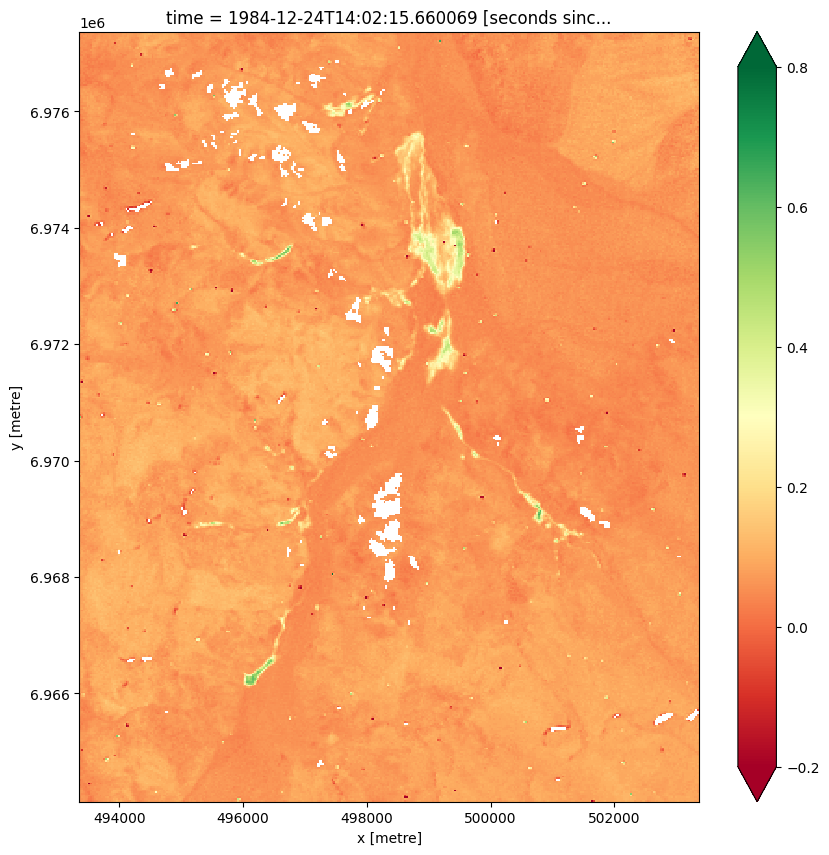

In [16]:
plt.figure(figsize=(10, 10))
ndvi.isel(time=0).plot(cmap="RdYlGn", vmin=-.2, vmax=.8)
plt.show()

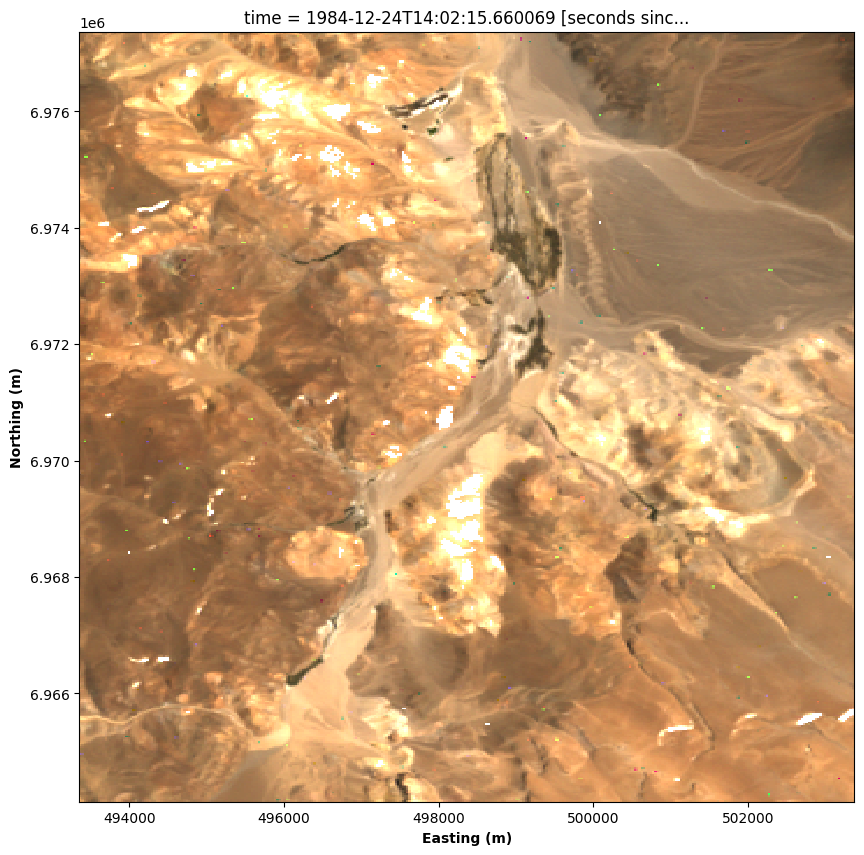

In [17]:
dsf[["red", "green", "blue"]].isel(time=0).to_array().plot.imshow(vmin=0,vmax=.3,figsize=(10,10))

# Set the title and axis labels
ax = plt.gca()
ax.set_xlabel('Easting (m)', fontweight='bold')
ax.set_ylabel('Northing (m)', fontweight='bold')

# Display the plot
plt.show()

Se agrega el NDVI como una variable más al cubo

In [18]:
dsf = dsf.assign(ndvi=ndvi)
dsf

<xarray.Dataset>
Dimensions:      (time: 864, y: 441, x: 334)
Coordinates:
  * time         (time) datetime64[ns] 1984-12-24T14:02:15.660069 ... 2022-12...
  * y            (y) float64 6.977e+06 6.977e+06 ... 6.964e+06 6.964e+06
  * x            (x) float64 4.934e+05 4.934e+05 ... 5.033e+05 5.034e+05
    spatial_ref  int32 32719
Data variables:
    red          (time, y, x) float64 dask.array<chunksize=(1, 441, 334), meta=np.ndarray>
    blue         (time, y, x) float64 dask.array<chunksize=(1, 441, 334), meta=np.ndarray>
    green        (time, y, x) float64 dask.array<chunksize=(1, 441, 334), meta=np.ndarray>
    nir          (time, y, x) float64 dask.array<chunksize=(1, 441, 334), meta=np.ndarray>
    ndvi         (time, y, x) float64 dask.array<chunksize=(1, 441, 334), meta=np.ndarray>
Attributes:
    crs:           EPSG:32719
    grid_mapping:  spatial_ref

## Revisando sólo las zonas de interés (humedales)

Es necesario descargar los archivos vectoriales que contienen los humedales. En este caso, se usarán los del ministerio de medio ambiente, para el año 2015, los que pueden ser visualizados y descargados en el [visor oficial](https://gis.mma.gob.cl/portal/apps/webappviewer/index.html?id=19ff876d63ed4a53aef1a57e39370474). Para ir directo a la descarga, se puede usar este otro [sitio](https://humedaleschile.mma.gob.cl/inventario-humadales/) del ministerio.

In [19]:
import urllib.request
import os

if not os.path.exists("humedales_vector.zip"):
    urllib.request.urlretrieve("https://humedaleschile.mma.gob.cl/wp-content/uploads/2017/10/inventario_humedales_publico.gdb.zip", "humedales_vector.zip")

In [20]:
import geopandas as gpd
import rasterstats as rs
import pyproj
from shapely.geometry import Polygon

In [21]:
humedales = gpd.read_file('zip://humedales_vector.zip!Inventario_humedales_publico.gdb', layer='inventario_plataforma')

In [22]:
y0, y1 = study_area_lat
x1, x0 = study_area_lon
polygon = Polygon([(x0, y0), (x0, y1), (x1, y1), (x1, y0), (x0, y0)])
clipper = gpd.GeoDataFrame([1], geometry=[polygon], crs=pyproj.CRS("EPSG:4326"))
clipper = clipper.to_crs(humedales.crs)
# clipper.plot()
humedales_ = gpd.clip(humedales, clipper)
humedales_ = humedales_.loc[humedales_.Clase != "Rios"]

Más información sobre [como armar geometrías y como cortar geometrías](https://geopandas.org/gallery/plot_clip.html). Un vistazo al archivo vectorial:

<AxesSubplot:>

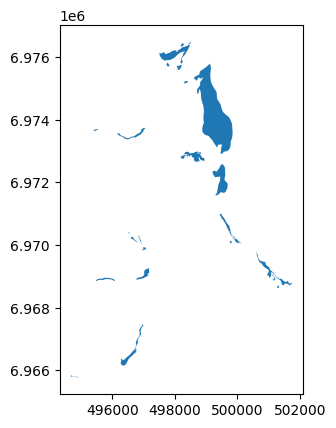

In [23]:
humedales_.plot()

<AxesSubplot:>

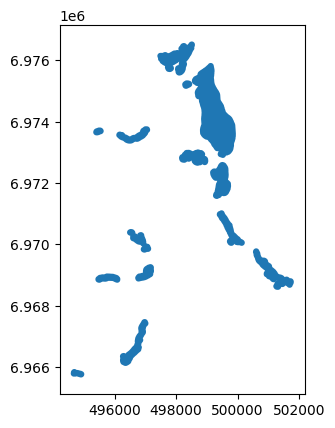

In [24]:
humedales_or = humedales_.copy()
humedales_['geometry'] = humedales_.geometry.buffer(100)
humedales_.plot()

## Agrupar datos por tiempo

En primera instancia, calcular la mediana entre los meses de diciembre, enero, febrero y marzo de cada año. Primero, se arma un vector con las fechas de interés que están en el cubo, y se genera un subset

In [25]:
summer_dates = dsf.time[ds.time.dt.month.isin([12, 1, 2, 3])]
ds_summer = dsf.sel(time=summer_dates)

Es necesario generar una variable por temporada. Diciembre (12), pertenece al año anterior, por lo que no se puede utilizar el año directamente. Se toma la coordenada de base `time` y se le adicionan 31 días (aquí nos interesa el año, no el mes, por lo tanto no hay problema al hacerlo de esta forma).

In [26]:
ds_summer = ds_summer.assign_coords(season=(ds_summer.time + np.timedelta64(31, 'D')))
ds_summer

<xarray.Dataset>
Dimensions:      (time: 293, y: 441, x: 334)
Coordinates:
  * time         (time) datetime64[ns] 1984-12-24T14:02:15.660069 ... 2022-12...
  * y            (y) float64 6.977e+06 6.977e+06 ... 6.964e+06 6.964e+06
  * x            (x) float64 4.934e+05 4.934e+05 ... 5.033e+05 5.034e+05
    spatial_ref  int32 32719
    season       (time) datetime64[ns] 1985-01-24T14:02:15.660069 ... 2023-01...
Data variables:
    red          (time, y, x) float64 dask.array<chunksize=(1, 441, 334), meta=np.ndarray>
    blue         (time, y, x) float64 dask.array<chunksize=(1, 441, 334), meta=np.ndarray>
    green        (time, y, x) float64 dask.array<chunksize=(1, 441, 334), meta=np.ndarray>
    nir          (time, y, x) float64 dask.array<chunksize=(1, 441, 334), meta=np.ndarray>
    ndvi         (time, y, x) float64 dask.array<chunksize=(1, 441, 334), meta=np.ndarray>
Attributes:
    crs:           EPSG:32719
    grid_mapping:  spatial_ref

La coordenada ha sido añadida satisfactoriamente, por lo que ahora se puede usar como variable de agrupamiento y calcular la mediana de la temporada (ignorando valores ausentes)

In [27]:
# ds_summer = ds_summer.groupby('season.year').reduce(np.nanmean)  # más lento: favorecer las funciones de xarray
ds_summer_ag = ds_summer.groupby('season.year').median(skipna=True).persist()
# ds_summer = ds_summer.groupby('season.year').mean(skipna=True)
ds_summer_ag

<xarray.Dataset>
Dimensions:      (year: 39, y: 441, x: 334)
Coordinates:
  * y            (y) float64 6.977e+06 6.977e+06 ... 6.964e+06 6.964e+06
  * x            (x) float64 4.934e+05 4.934e+05 ... 5.033e+05 5.034e+05
    spatial_ref  int32 32719
  * year         (year) int64 1985 1986 1987 1988 1989 ... 2020 2021 2022 2023
Data variables:
    red          (year, y, x) float64 dask.array<chunksize=(1, 441, 334), meta=np.ndarray>
    blue         (year, y, x) float64 dask.array<chunksize=(1, 441, 334), meta=np.ndarray>
    green        (year, y, x) float64 dask.array<chunksize=(1, 441, 334), meta=np.ndarray>
    nir          (year, y, x) float64 dask.array<chunksize=(1, 441, 334), meta=np.ndarray>
    ndvi         (year, y, x) float64 dask.array<chunksize=(1, 441, 334), meta=np.ndarray>

La serie temporal agregada está lista, podemos visualizarla para el 2014 (en color y el índice NDVI):

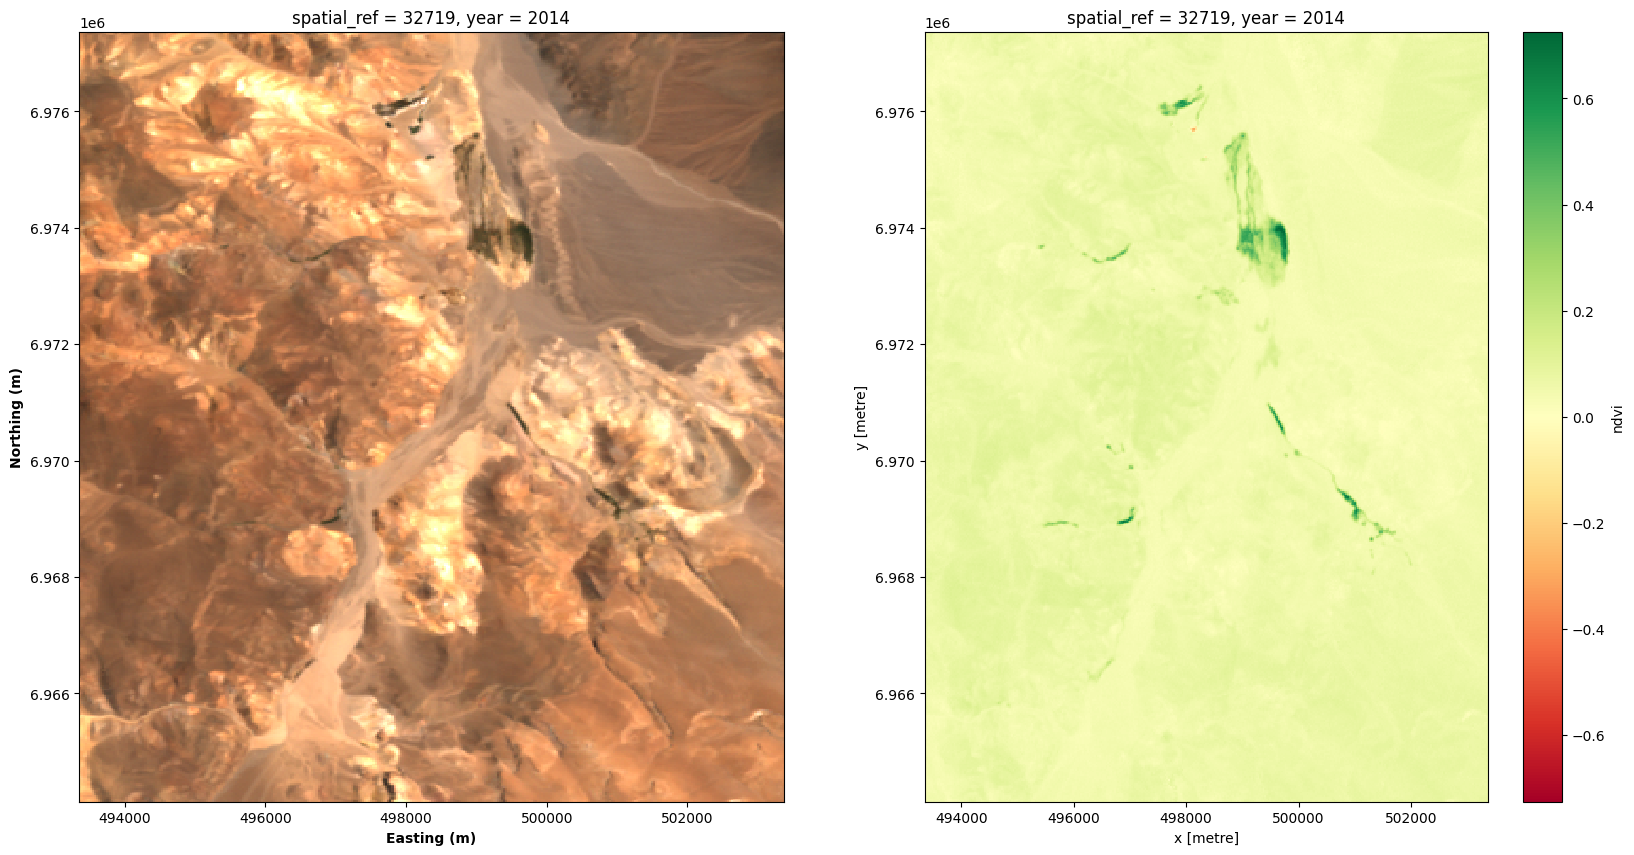

In [28]:
fig = plt.figure(figsize=(20,10))
ax1 = fig.add_subplot(121)

ds_summer_ag[["red", "green", "blue"]].sel(year=2014).to_array().plot.imshow(vmin=0,vmax=.3,ax=ax1) #figsize=(10,10)
ax1.set_xlabel('Easting (m)', fontweight='bold')
ax1.set_ylabel('Northing (m)', fontweight='bold')

ax2 = fig.add_subplot(122)
ds_summer_ag['ndvi'].sel(year=2014).plot.imshow(cmap="RdYlGn", ax=ax2)

Si se enmascara la zona particular de estudio, el resultado se ve más limpio:

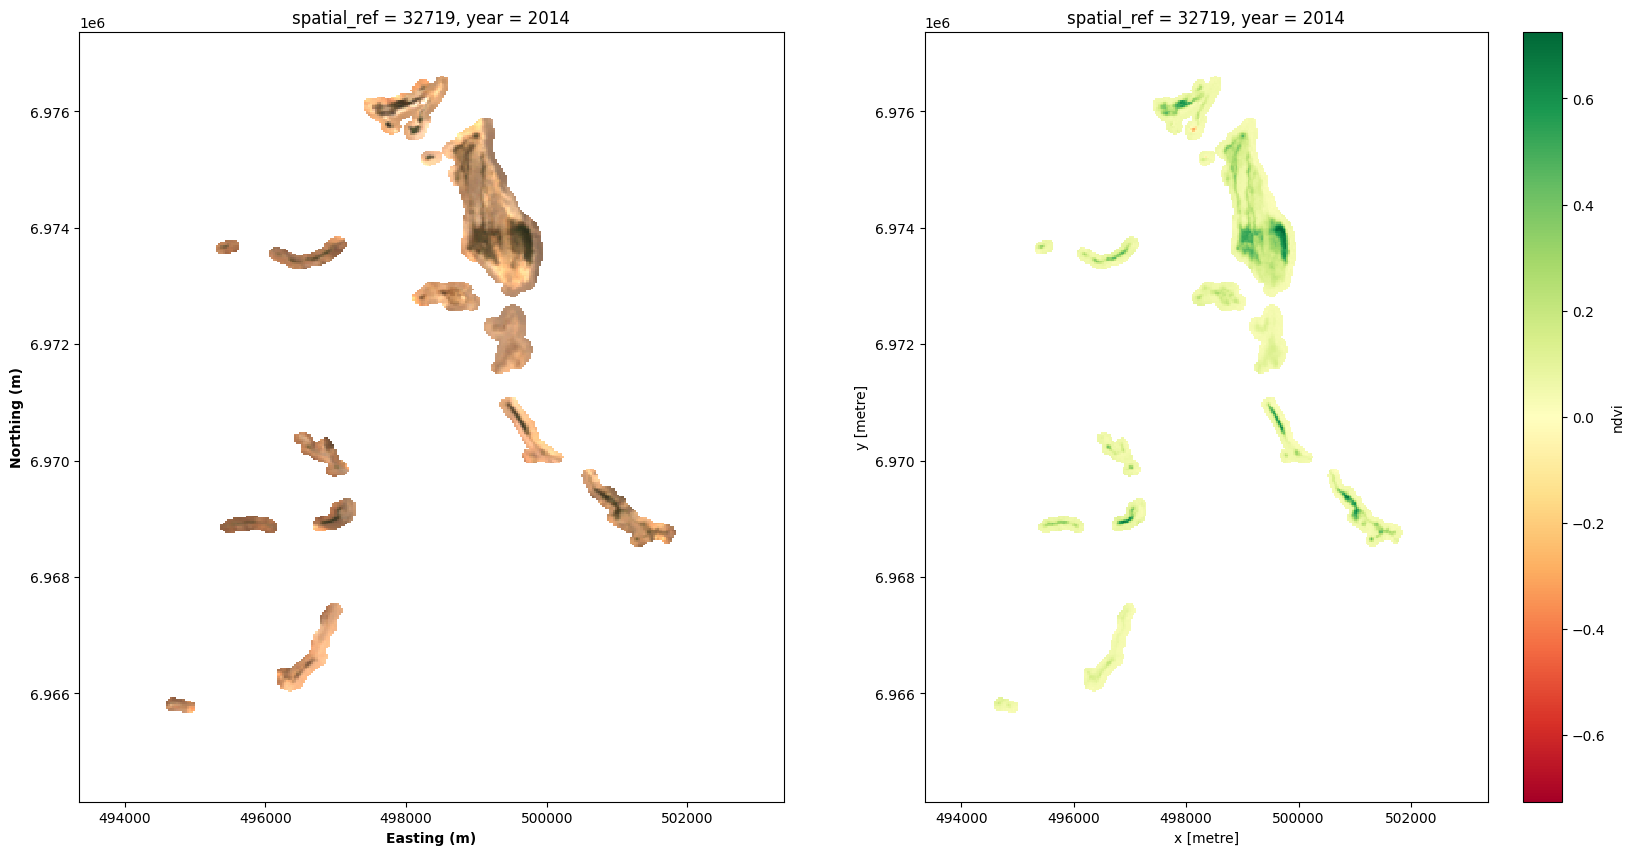

In [29]:
import rasterio as rio

smask = rio.features.geometry_mask(humedales_.geometry, 
                                   out_shape=(len(ds.y), len(ds.x)),
                                   transform=ds.geobox.transform,
                                   invert=True)

ds_summer_masked = ds_summer_ag.where(smask)


fig = plt.figure(figsize=(20,10))
ax1 = fig.add_subplot(121)

ds_summer_masked[["red", "green", "blue"]].sel(year=2014).to_array().plot.imshow(vmin=0,vmax=.3,ax=ax1) #figsize=(10,10)
ax1.set_xlabel('Easting (m)', fontweight='bold')
ax1.set_ylabel('Northing (m)', fontweight='bold')

ax2 = fig.add_subplot(122)
ds_summer_masked['ndvi'].sel(year=2014).plot.imshow(cmap="RdYlGn", ax=ax2)

Y si además se sobreponen los contornos:

<AxesSubplot:title={'center':'spatial_ref = 32719, year = 2014'}, xlabel='x [metre]', ylabel='y [metre]'>

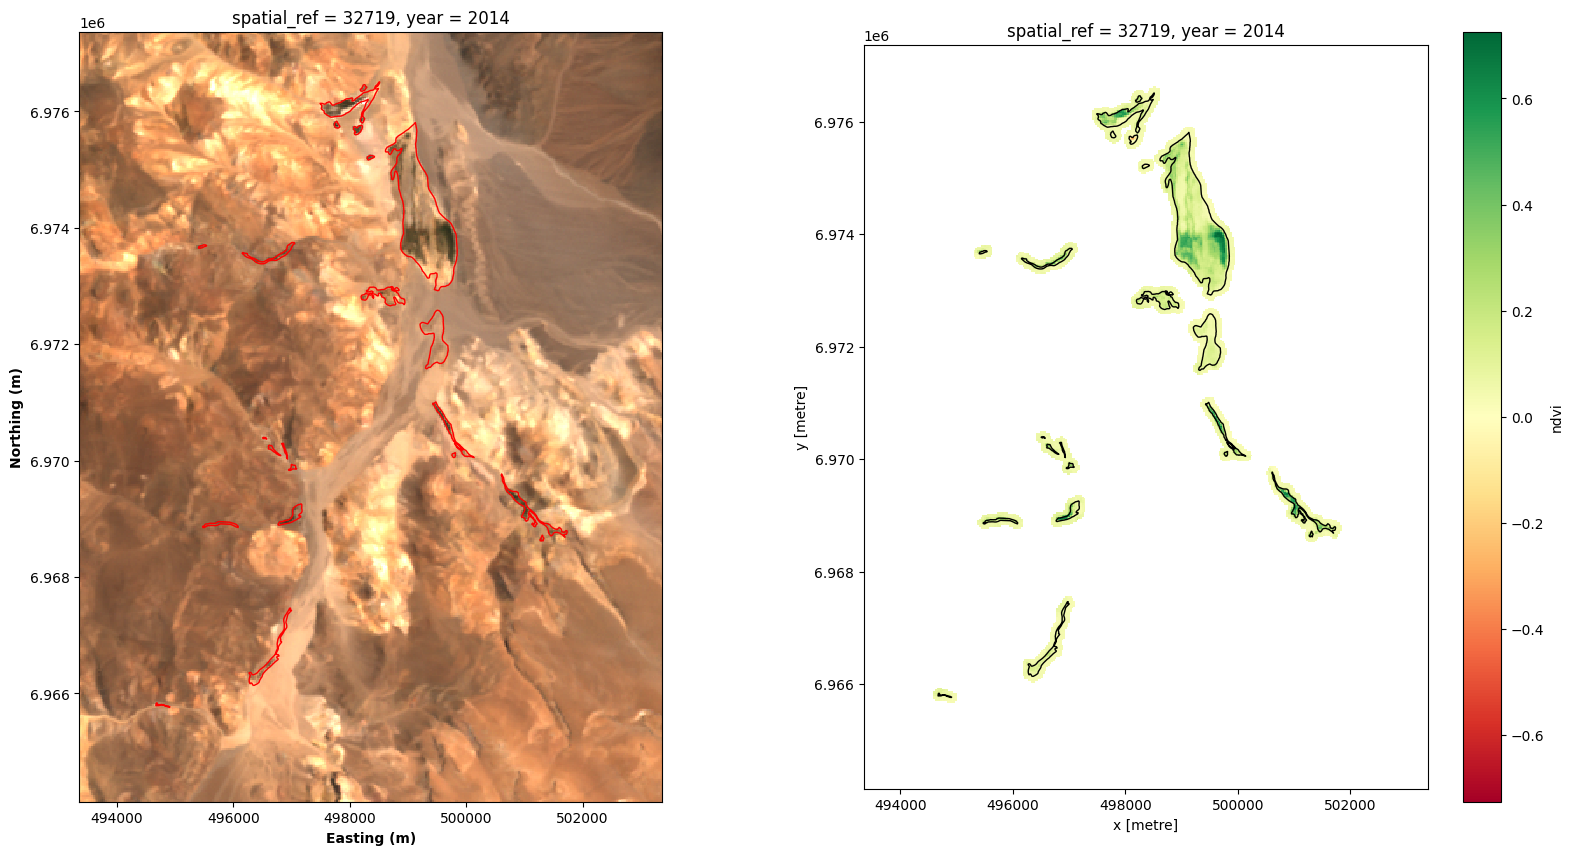

In [30]:
fig = plt.figure(figsize=(20,10))
ax1 = fig.add_subplot(121)

ds_summer_ag[["red", "green", "blue"]].sel(year=2014).to_array().plot.imshow(vmin=0,vmax=.3,ax=ax1) #figsize=(10,10)
humedales_or.plot(ax=ax1, facecolor='none', edgecolor='red')
ax1.set_xlabel('Easting (m)', fontweight='bold')
ax1.set_ylabel('Northing (m)', fontweight='bold')

ax2 = fig.add_subplot(122)
ds_summer_masked['ndvi'].sel(year=2014).plot.imshow(cmap="RdYlGn", ax=ax2)
humedales_or.plot(ax=ax2, facecolor='none', edgecolor='black')

Finalmente, la información puede ser exportada como netcdf, para ser utilizada en otras plataformas/programas

In [31]:
from datacube.drivers.netcdf import write_dataset_to_netcdf
import warnings
warnings.filterwarnings('ignore')

if os.path.exists('humedales.nc'):
    os.remove('humedales.nc')
    
write_dataset_to_netcdf(ds_summer_masked, 'humedales.nc')

## Extracción de datos por zona (zonal statitics)

Se itera por cada año y extraemos las estadísticas. Hay que procurar que tanto el archivo vectorial como el xarray tengan el mismo CRS. 

In [32]:
my_stats = []
for i, date in enumerate(ds_summer_ag.year.values):
    if i % 5 == 0:
        print('{} - {}'.format(i, date))
    temp = rs.zonal_stats(humedales_, 
                          ds_summer_ag.ndvi.isel(year=i).values, 
                          affine=ndvi.affine, 
                          stats="count min mean max median std", 
                          nodata=np.nan) # especificar no data, solo para evitar advertencias. Los valores NA ya están como np.nan
    temp_ = pd.merge(pd.DataFrame(humedales_.reset_index().drop(columns="geometry")), 
                             pd.DataFrame(temp), 
                             left_index=True, 
                             right_index=True)
    temp_['Año'] = date
    my_stats.append(temp_)

0 - 1985
5 - 1990
10 - 1995
15 - 2000
20 - 2005
25 - 2010
30 - 2015
35 - 2020


Se puede seleccionar un humedal en particular

<AxesSubplot:xlabel='Año'>

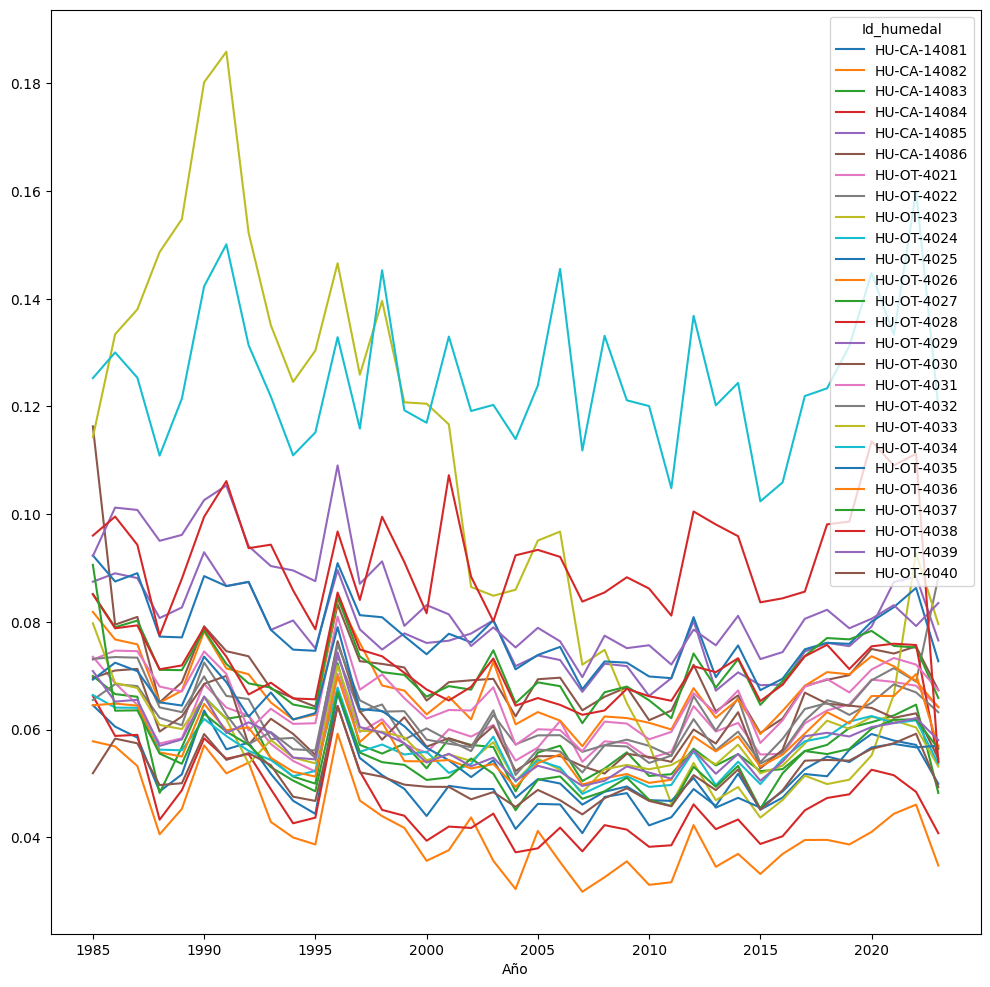

In [33]:
serie_temporal = pd.concat(my_stats)
pd.pivot(serie_temporal, index="Año", columns='Id_humedal', values="median").plot(figsize=(12,12))

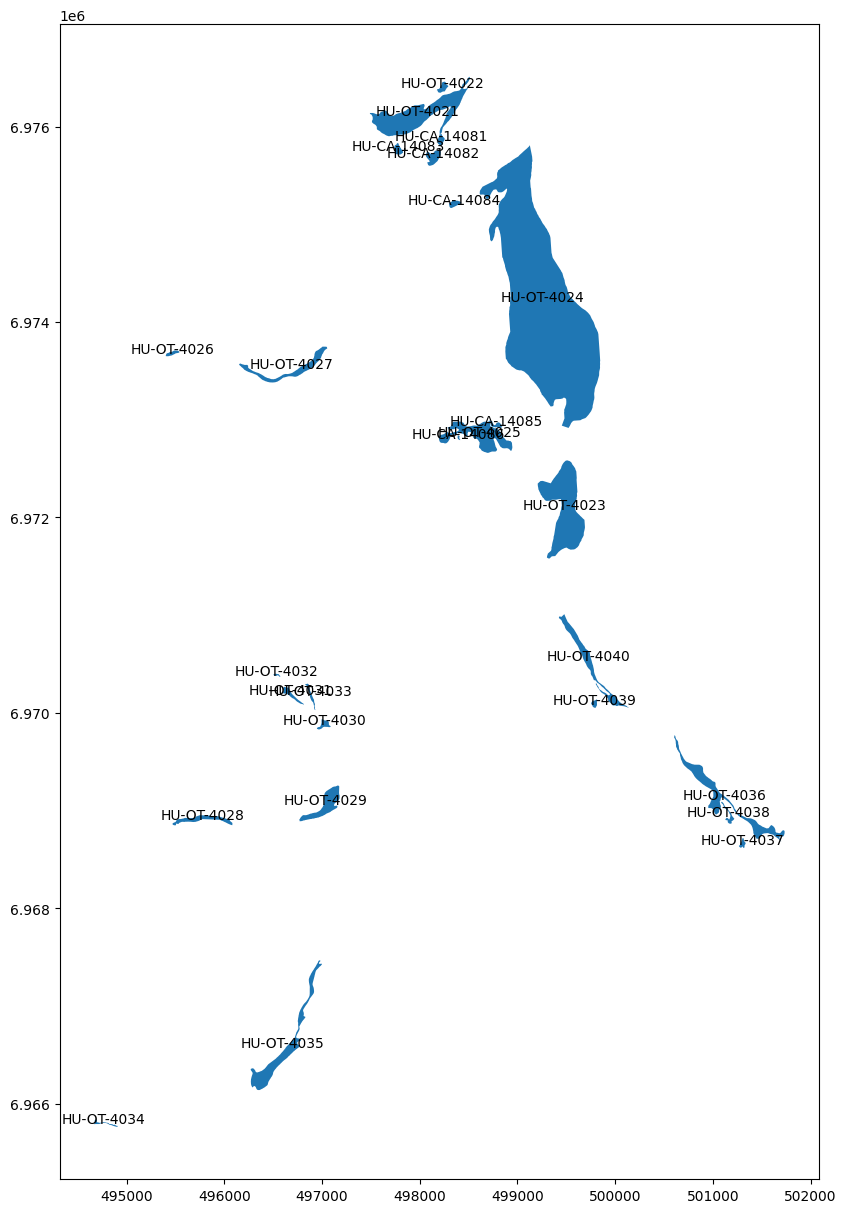

In [34]:
ax = humedales_or.plot(figsize=(15, 15))
humedales_or.apply(lambda x: ax.annotate(text=x.Id_humedal, xy=x.geometry.centroid.coords[0], ha='center'),axis=1);

Los humedales de interés son:

In [35]:
humedales_id = ['HU-OT-4023', # humedal objetivo
               'HU-OT-4028', 'HU-OT-4029', 'HU-OT-4030', 'HU-OT-4031', 'HU-OT-4033', 'HU-OT-4040'] # humedales control

Aislando el humedal objetivo:

<AxesSubplot:xlabel='Año'>

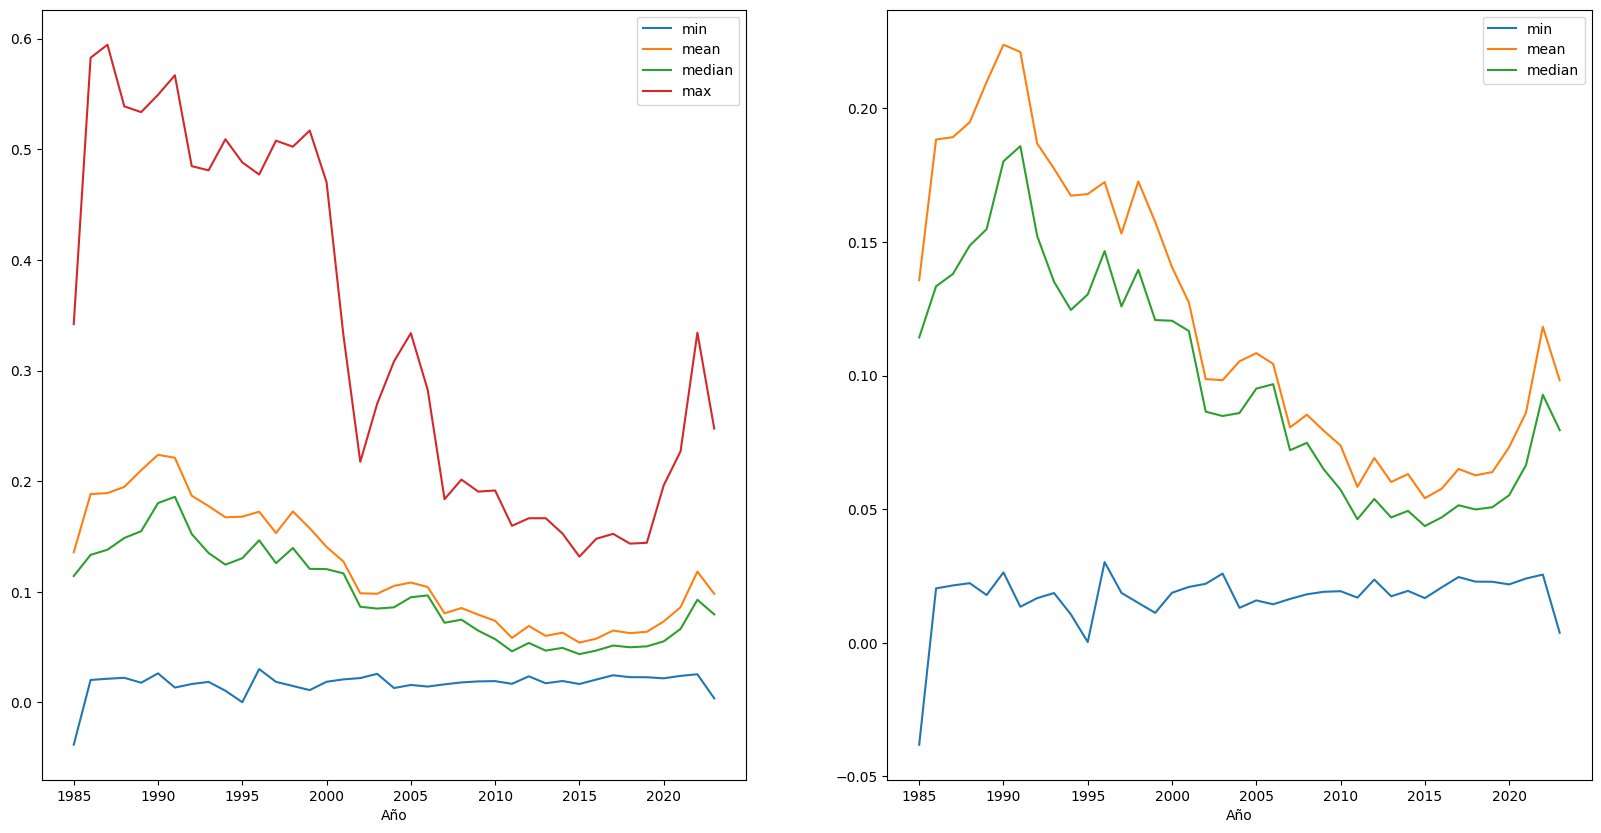

In [36]:
fig = plt.figure(figsize=(20,10))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

agg_ = serie_temporal.loc[serie_temporal.Id_humedal == humedales_id[0]].set_index('Año')[['min', 'mean', 'median', 'max']]

agg_.plot(ax = ax1) #, subplots=True)
agg_[['min', 'mean', 'median']].plot(ax = ax2) #, subplots=True)

Comparando el humedal objetivo con los de control (en su media y viendo su tendencia general):

<AxesSubplot:xlabel='Año'>

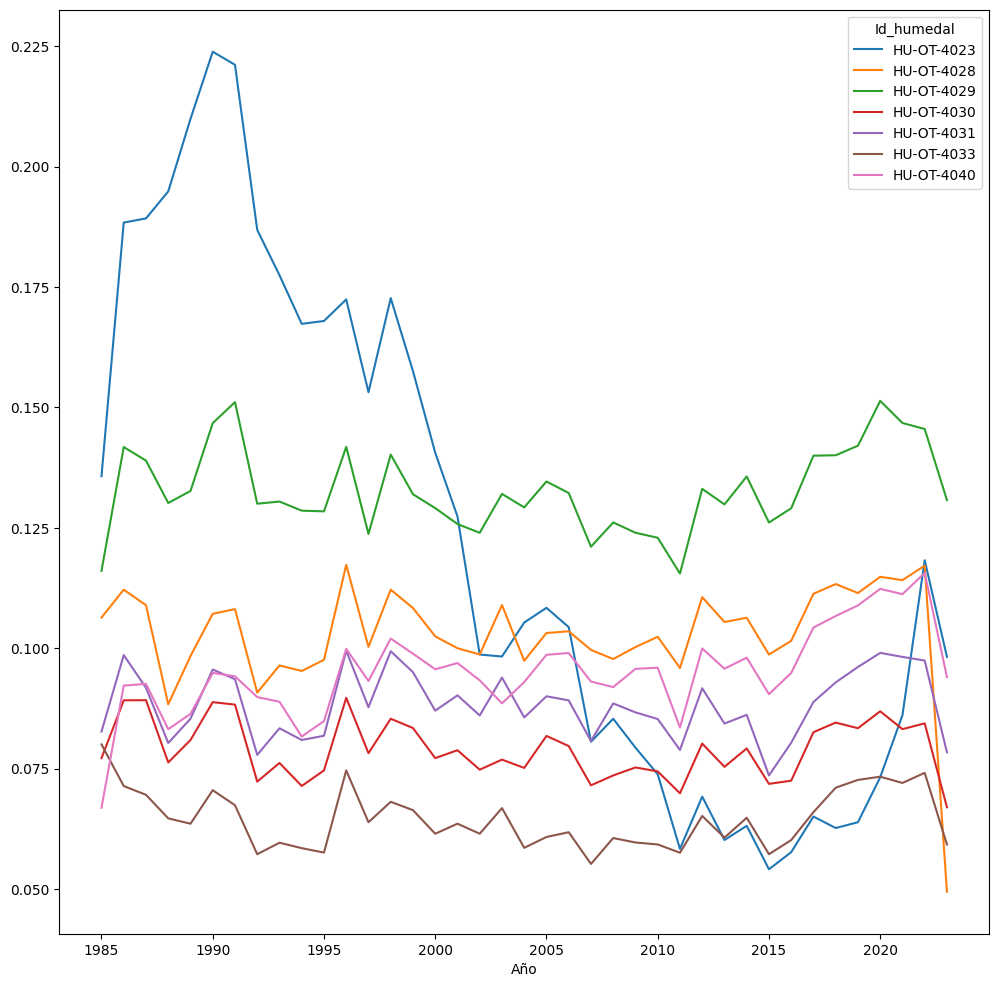

In [37]:
compara = serie_temporal.loc[serie_temporal.Id_humedal.isin(humedales_id)][['Año', 'Id_humedal', 'mean']]
pd.pivot(compara, index="Año", columns='Id_humedal', values="mean").plot(figsize=(12,12))

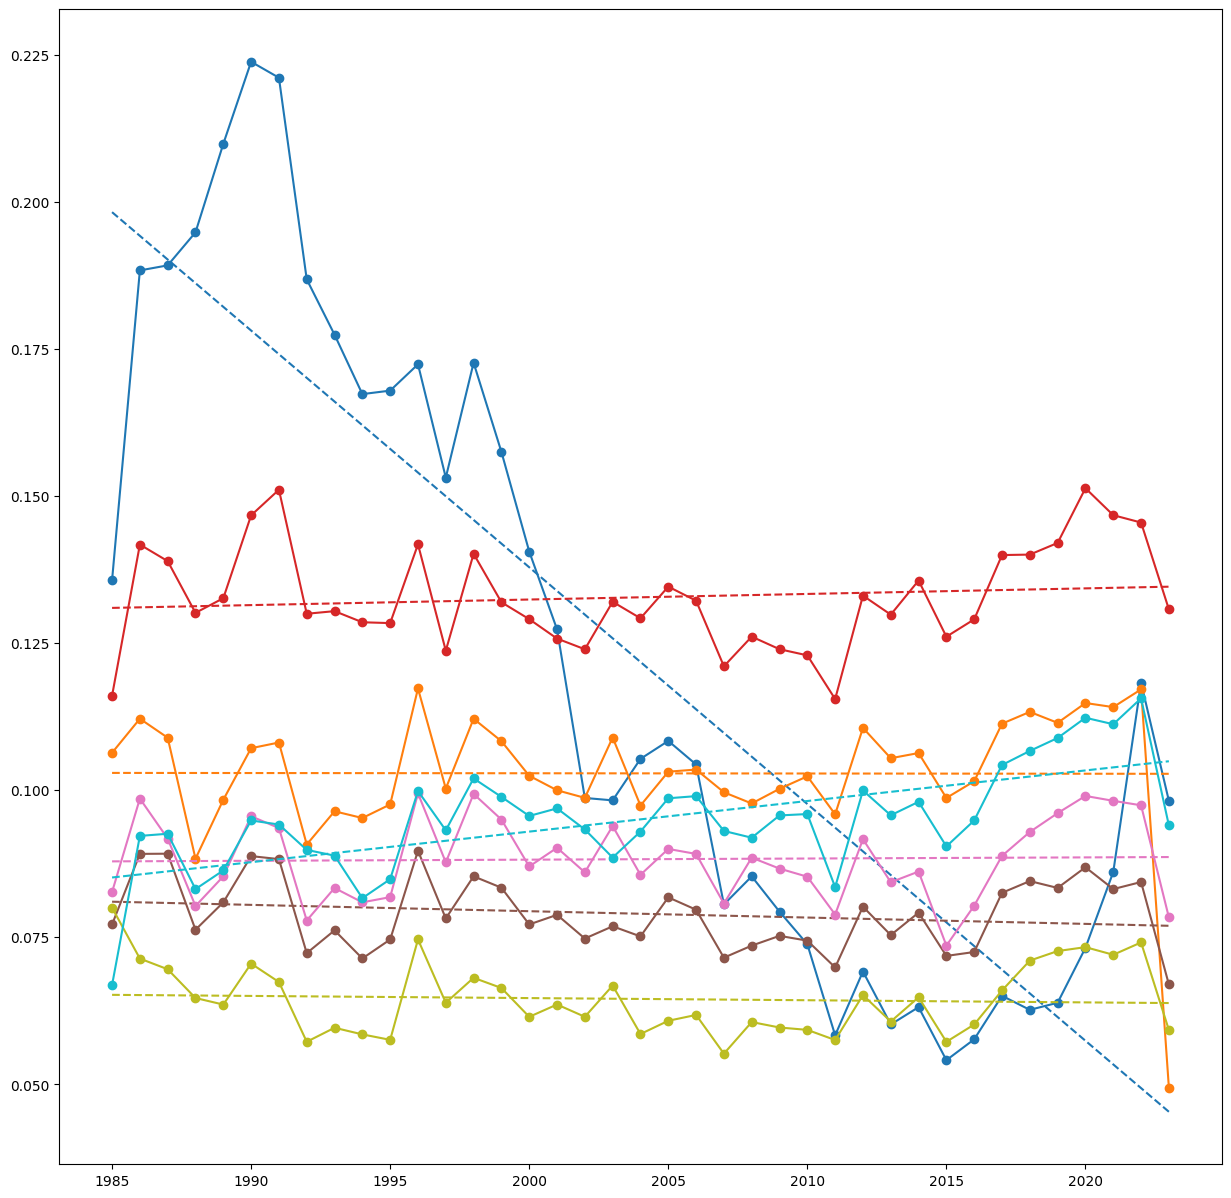

In [38]:
cmap = plt.cm.tab10
colores = cmap(np.linspace(0, 1, len(humedales_id)))
colores = {humedales_id[i]: colores[i] for i in range(len(humedales_id))}

fig, ax = plt.subplots(figsize=(15, 15))

for i in humedales_id:
    temp = serie_temporal.loc[serie_temporal.Id_humedal == i]
    x, y = temp[['Año', 'mean']].T.to_numpy()
    plt.plot(x, y, '-o', color=colores[i])
    z = np.polyfit(x, y, 1)
    p = np.poly1d(z)
    plt.plot(x, p(x), "--", color=colores[i])

Los resultados son bastante similares a los obtenidos por el MMA y se ve claramente que el humedal en cuestión (HU-OT-4023, en azul), tiene un marcado descenso que no está presente en el resto de los humedales

## *Siguientes pasos*

Para continuar el entrenamiento, un listado con los notebooks de esta sesión

1. [Acceso y configuración](00_Acceso_configuración.ipynb)
2. [Cargar datos](01_Carga_datos.ipynb)
3. [Análisis básico](02_Análisis_básico.ipynb)
4. **Estudio de caso**
5. [Trabajo final](04_Actividad_final.ipynb)